In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

In [2]:
#originally downloaded here: https://gis-kingcounty.opendata.arcgis.com/datasets/transit-stops-for-king-county-metro-transitstop-point/explore
#my copy available here: https://drive.google.com/file/d/1EyHIIKw29yl3fOt4lM6ft-XtBMkKkzv_/view?usp=sharing
gdf_stops = gpd.read_file("data/transit/metro/Transit_Stops_for_King_County_Metro___transitstop_point.zip")
#made by the metro_data_cleaning.ipynb notebook in this repo
df_ridership = pd.read_parquet("data/cleaned_metro_ridership.parquet")

gdf_merged = gdf_stops.merge(
    df_ridership,
    left_on="STOP_ID",
    right_on="stop_id",
)
size_multipliers = {
    0: 0.01,
    1: 0.5,
    2: 0.75,
    3: 1,
    4: 2,
}
gdf_merged["post_size_category"] = gdf_merged["postpandemic_avg_daily_boardings"].apply(
    lambda b:
    1 if b < 10 else
    2 if b < 25 else
    3 if b < 75 else
    4 if pd.notna(b) else
    0
)
gdf_merged["post_size_multiplier"] = gdf_merged["post_size_category"].apply(lambda c: size_multipliers[c])

In [6]:
gdf_less = gdf_merged[[
    "geometry",
    "route_number",
    "stop_id",
    "postpandemic_avg_daily_boardings",
    "prepandemic_avg_daily_boardings",
    "post_size_category",
    "post_size_multiplier",
    "AUTH_NAME"
]].copy()
gdf_less = gdf_less.to_crs("EPSG:3857") # convert to web mercator
gdf_less["geometry"] = gdf_less["geometry"].buffer(100)
gdf_less["post:pre_ridership_ratio"] = (gdf_less["postpandemic_avg_daily_boardings"].fillna(0) + 0.01) / (gdf_less["prepandemic_avg_daily_boardings"].fillna(0) + 0.01)
gdf_less["post:pre_ridership_ratio"] = gdf_less["post:pre_ridership_ratio"].apply(lambda r: r if r < 3 else 3)

In [15]:
gdf_less[gdf_less["route_number"] == 250].drop_duplicates(subset="stop_id").explore(
    column="postpandemic_avg_daily_boardings"
)

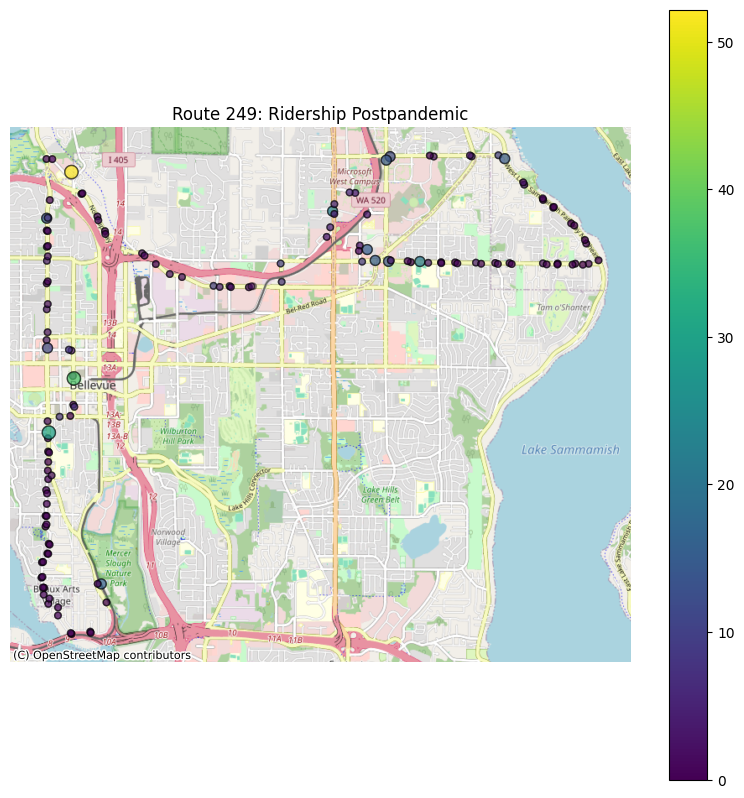

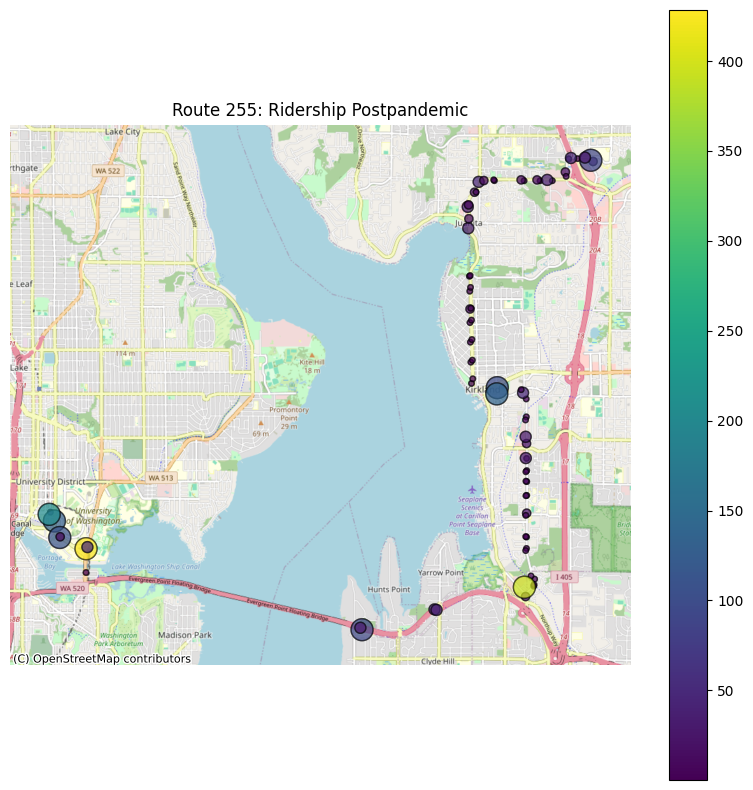

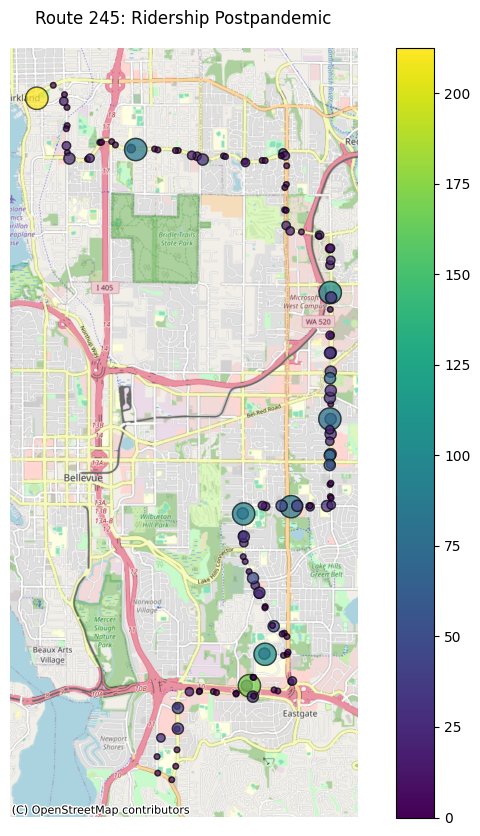

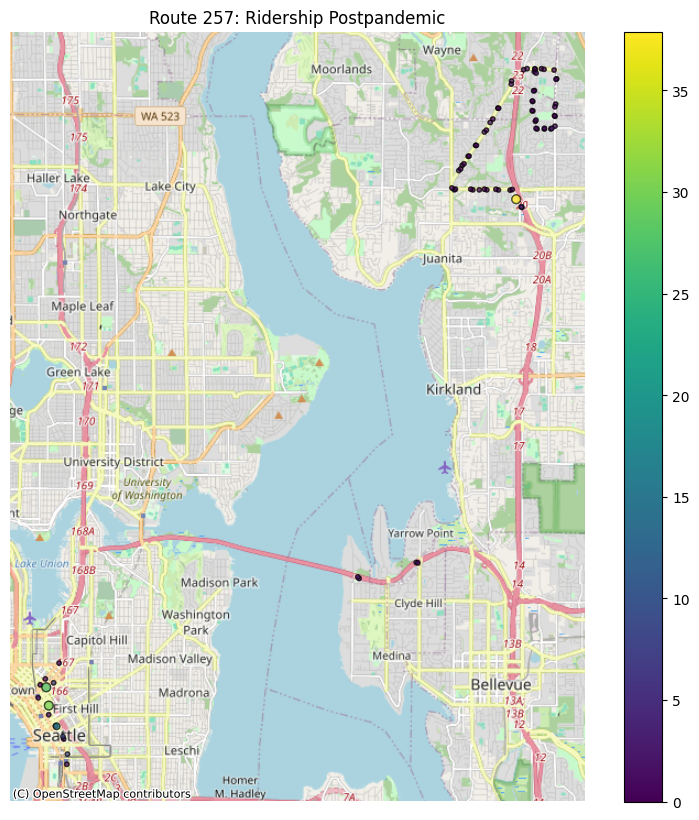

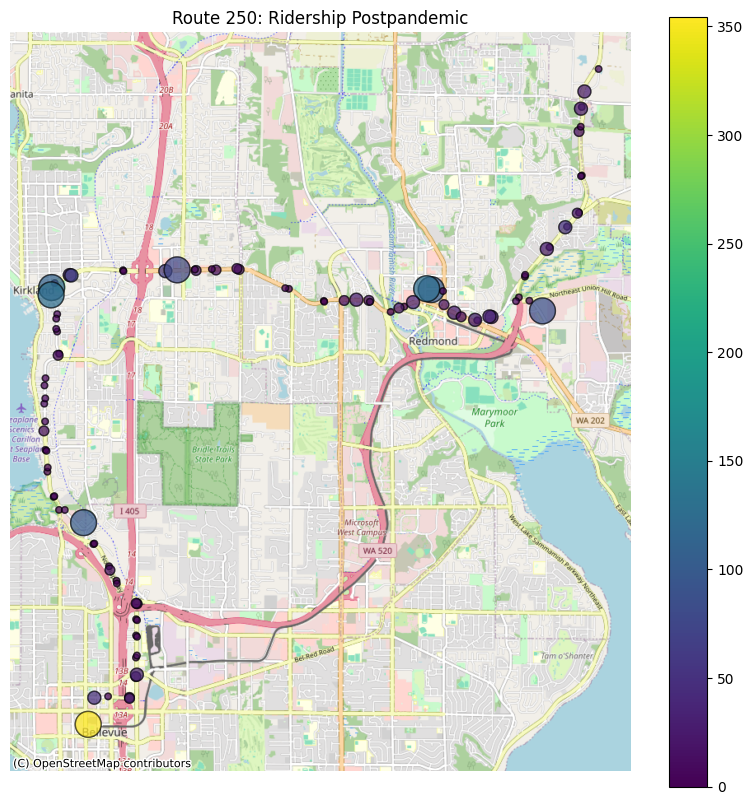

In [11]:
buffer_base = 150
gdf_buffer = gdf_merged[[
    "geometry",
    "route_number",
    "stop_id",
    "postpandemic_avg_daily_boardings",
    "prepandemic_avg_daily_boardings",
    "post_size_multiplier",
    "post_size_category",
    "AUTH_NAME",
]].copy().to_crs("EPSG:3857")
gdf_buffer["geometry"] = gdf_buffer.apply(
    lambda r:
    r["geometry"].buffer(buffer_base * r["post_size_multiplier"]),
    axis=1,
)

for route_number in gdf_buffer[gdf_buffer["postpandemic_avg_daily_boardings"].notna()]["route_number"].unique():
    vmax = None
    if route_number == 255:
        vmax = None
    ax = gdf_buffer[
        (gdf_buffer["route_number"] == route_number)
        & (gdf_buffer["postpandemic_avg_daily_boardings"].notna())
    ].plot(
        column="postpandemic_avg_daily_boardings",
        alpha=0.35,
        figsize=(10,10),
        legend=True,
        vmax=vmax,
        edgecolor="black",
    )
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    ax.axis("off")
    plt.title(f"Route {route_number}: Ridership Postpandemic")

# Kirkland Only Maps

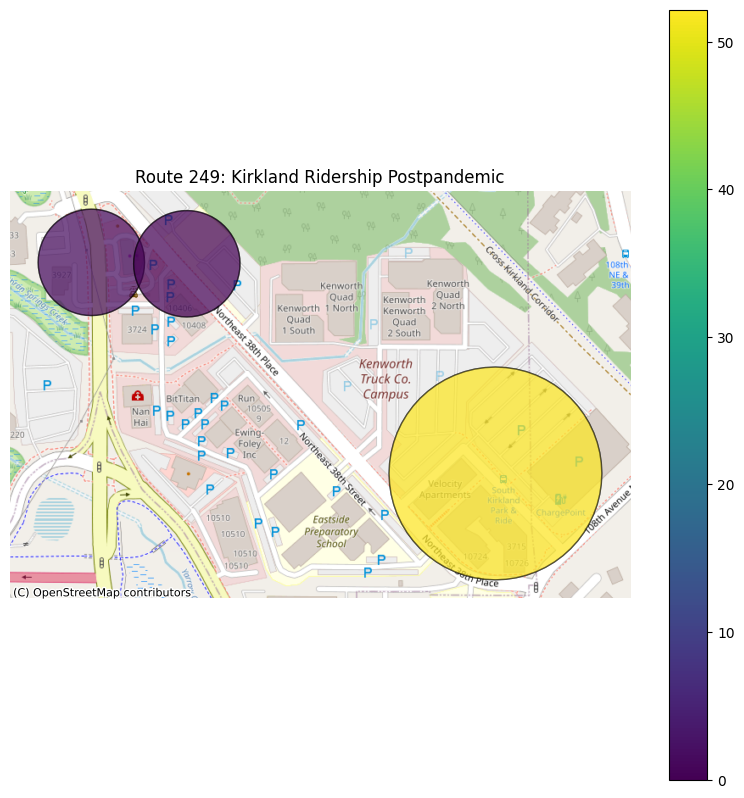

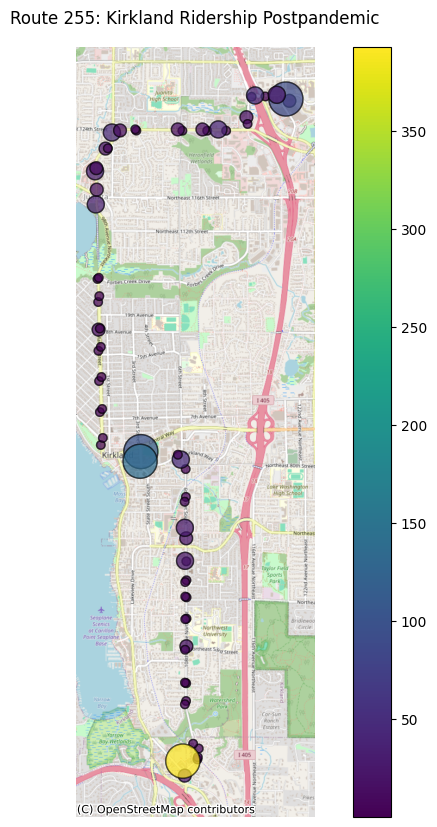

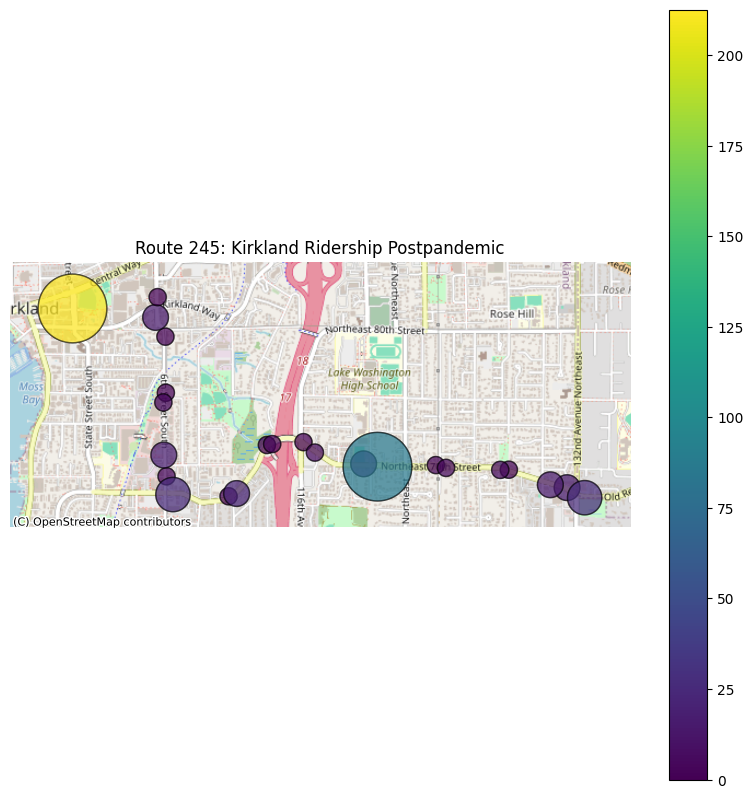

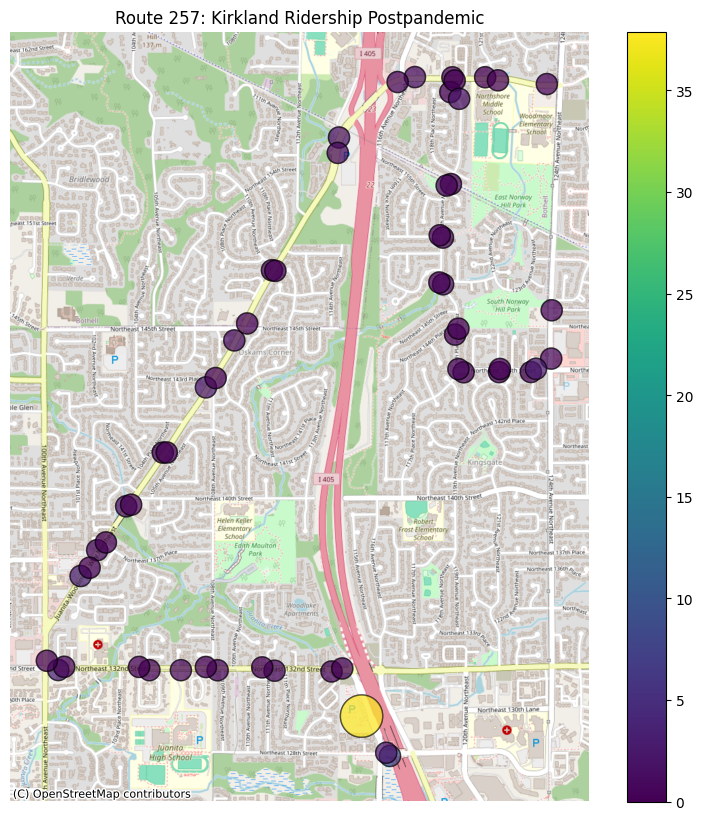

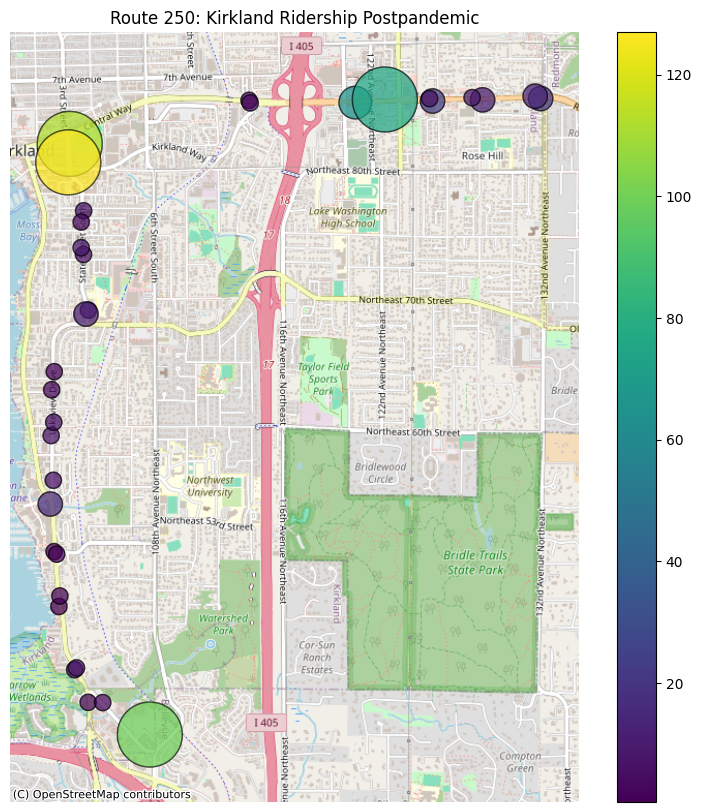

In [18]:
buffer_base = 150
gdf_buffer = gdf_merged[[
    "geometry",
    "route_number",
    "stop_id",
    "postpandemic_avg_daily_boardings",
    "prepandemic_avg_daily_boardings",
    "post_size_multiplier",
    "post_size_category",
    "AUTH_NAME",
]].copy().to_crs("EPSG:3857")
gdf_buffer["geometry"] = gdf_buffer.apply(
    lambda r:
    r["geometry"].buffer(buffer_base * r["post_size_multiplier"]),
    axis=1,
)

for route_number in gdf_buffer[gdf_buffer["postpandemic_avg_daily_boardings"].notna()]["route_number"].unique():
    vmax = None
    if route_number == 255:
        vmax = None
    ax = gdf_buffer[
        (gdf_buffer["route_number"] == route_number)
        & (gdf_buffer["postpandemic_avg_daily_boardings"].notna())
        & (
            (gdf_buffer["AUTH_NAME"] == "Kirkland") |
            (gdf_buffer["AUTH_NAME"] == "King County") |
            (gdf_buffer["stop_id"].isin(
                [
                    74460,
                    74450,
                    85040,
                    74442,
                    74533,
                    74441,
                ]
            ))
        )
        & (~gdf_buffer["stop_id"].isin(
            [
                64835,
                69150,
                69160,
                84015,
                72540,
                72560,
                71830,
            ]
        ))
    ].plot(
        column="postpandemic_avg_daily_boardings",
        alpha=0.35,
        figsize=(10,10),
        legend=True,
        vmax=vmax,
        edgecolor="black",
    )
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    ax.axis("off")
    plt.title(f"Route {route_number}: Kirkland Ridership Postpandemic")

In [19]:
gdf_less

geometry  route_number  \
0     POLYGON ((-13596029.192 6046839.686, -13596029...           249   
1     POLYGON ((-13596029.192 6046839.686, -13596029...           249   
2     POLYGON ((-13596029.192 6046839.686, -13596029...           249   
3     POLYGON ((-13601119.537 6065101.450, -13601120...           231   
4     POLYGON ((-13601119.537 6065101.450, -13601120...           239   
...                                                 ...           ...   
3019  POLYGON ((-13601234.253 6068531.160, -13601234...           230   
3020  POLYGON ((-13601234.253 6068531.160, -13601234...           230   
3021  POLYGON ((-13599338.253 6066124.410, -13599338...           231   
3022  POLYGON ((-13599338.253 6066124.410, -13599338...           231   
3023  POLYGON ((-13599338.253 6066124.410, -13599338...           231   

      stop_id  postpandemic_avg_daily_boardings  \
0       66875                               2.7   
1       66875                               2.7   
2       66875                               2.7   
3       70317                               NaN   
4       70317                               NaN   
...       ...                               ...   
3019    76009                               NaN   
3020    76009                               NaN   
3021    76010                               NaN   
3022    76010                               NaN   
3023    76010                               NaN   

      prepandemic_avg_daily_boardings  post_size_category  \
0                                 NaN                   1   
1                                 NaN                   1   
2                                 NaN                   1   
3                                 0.4                   0   
4                                 0.2                   0   
...                               ...                 ...   
3019                             12.4                   0   
3020                             12.4                   0   
3021                              9.5                   0   
3022                              9.5                   0   
3023                              9.5                   0   

      post_size_multiplier    AUTH_NAME  post:pre_ridership_ratio  
0                     0.50      Unknown                  3.000000  
1                     0.50      Unknown                  3.000000  
2                     0.50      Unknown                  3.000000  
3                     0.01      Unknown                  0.024390  
4                     0.01      Unknown                  0.047619  
...                    ...          ...                       ...  
3019                  0.01      Bothell                  0.000806  
3020                  0.01      Bothell                  0.000806  
3021                  0.01  Woodinville                  0.001052  
3022                  0.01  Woodinville                  0.001052  
3023                  0.01  Woodinville                  0.001052  

[3024 rows x 9 columns]